In [5]:
import os
import pandas as pd
import numpy as np
# from sklearn import linear_model
from scipy.stats import zscore
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
# import prol
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import seaborn as sns
from treeple.ensemble import PatchObliqueRandomForestRegressor
from sklearn.metrics import r2_score

In [6]:
print(os.getcwd())
data = np.load('group_data_natview_data_fmri_eyetracking1hz.npy',allow_pickle=True)
data_dict = data.item()
# data_dict['data_eyetracking']

/Users/qinazihan/Desktop/Jovo/Nov20


In [7]:
subjects = data_dict['subjects']
sessions = data_dict['sessions']
tasks = data_dict['tasks']
data_brainstates = data_dict['data_fmri']
data_eyetracking = data_dict['data_eyetracking']
brainstates = [ 'tsCAP1', 'tsCAP2', 'tsCAP3', 'tsCAP4', 'tsCAP5', 'tsCAP6', 'tsCAP7', 'tsCAP8']

In [8]:
def Data_Handeler(sub,session,state,task,window=12,mask_thr = 0.75):
    key = 'sub-' + sub+'_ses-'+session +'_task-'+ task
    fmri_ts_mask = (data_brainstates[key]['tsMask'].to_numpy() > 0.5)
    eyetrack_mask = (data_eyetracking[key]['tmask'].to_numpy() > 0.5)

    FMRI_TARGET_DATA = data_brainstates[key][state].to_numpy()
    PD_DATA = data_eyetracking[key]['pupil_size'].to_numpy()
    Xpos = data_eyetracking[key]['X_position'].to_numpy()
    Ypos = data_eyetracking[key]['Y_position'].to_numpy()

    PD_DATA_dfirst = np.diff(PD_DATA, prepend=PD_DATA[0])
    PD_DATA_dsecond = np.diff(PD_DATA, n=2, prepend=PD_DATA_dfirst[:2])
    PREDICTION_FEATURES = np.vstack((PD_DATA, PD_DATA_dfirst, PD_DATA_dsecond)).T
    
    PUPIL = []
    FMRI = []
    TIME = []
    for i in range(0,FMRI_TARGET_DATA.shape[0]-window):
        X = np.reshape(PREDICTION_FEATURES[(i):(i+window),: ].flatten(),(1,-1))
        FEATURE_MASK = eyetrack_mask[(i):(i+window)]
        Y = FMRI_TARGET_DATA[i+window]
        TARGET_MASK = fmri_ts_mask[i+window]
        if np.mean(FEATURE_MASK) >= 0.75 and TARGET_MASK:
            PUPIL.append(X)
            FMRI.append(Y)
            TIME.append(i+window)
    PUPIL_DF = np.concatenate(PUPIL)
    return PUPIL_DF,FMRI,TIME
    

In [9]:
# Time Encoding
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / (torch.arange(2, dim + 1, 2))
        self.freqs = self.freqs.unsqueeze(0)

    def forward(self, t):
        self.sin = torch.sin(self.freqs * t)
        self.cos = torch.cos(self.freqs * t)
        return torch.cat([self.sin, self.cos], dim=-1)

def Time_Handeler(t,tdim= 50):
    time_embed = TimeEmbedding(dim=tdim)
    timeembed = []
    for i in range(len(t)):
        timeembed.append(time_embed(t[i]))
    return np.concatenate(timeembed).reshape(-1,tdim)

In [10]:
def Train_Test(test_sub,SUBJECTS,session,state,tasks_list, time = False,model = 'ridge'):
    PUPIL_ALL = []
    FMRI_ALL = []
    TIME_ALL = []
    for sub_i in SUBJECTS:
        for task in tasks_list:
            PUPIL,FMRI,TIME = Data_Handeler(sub = sub_i,session =session,state = state,task = task,window=12,mask_thr = 0.75)
            if sub_i == test_sub:
                PUPIL_TEST = zscore(PUPIL,axis=1)
                FMRI_TEST = zscore(FMRI)
                TIME_TEST = TIME
            else:
                PUPIL_ALL.append(PUPIL)
                FMRI_ALL.extend(FMRI)
                TIME_ALL.extend(TIME)

    PUPIL_TRAIN = zscore(np.concatenate(PUPIL_ALL),axis = 1)
    FMRI_TRAIN = zscore(FMRI_ALL)
    TIME_TRAIN = TIME_ALL
    if model == 'ridge':
        reg = Ridge(alpha=1)    
    if model == 'rf':
        reg = RandomForestRegressor()
    if model == 'morf':
        reg = PatchObliqueRandomForestRegressor()
    if time:
        TIME_ENCODE_TRAIN = Time_Handeler(TIME_TRAIN)
        # print(TIME_ENCODE_TRAIN.shape)
        PUPIL_TRAIN_TIME = np.hstack((PUPIL_TRAIN,TIME_ENCODE_TRAIN))
        # print(PUPIL_TRAIN_TIME.shape)
        TIME_ENCODE_TEST = Time_Handeler(TIME_TEST)
        PUPIL_TEST_TIME = np.hstack((PUPIL_TEST,TIME_ENCODE_TEST))
    else:
        PUPIL_TRAIN_TIME = PUPIL_TRAIN
        PUPIL_TEST_TIME = PUPIL_TEST
    print(PUPIL_TRAIN_TIME.shape)
    reg.fit(PUPIL_TRAIN_TIME, FMRI_TRAIN)
    ypred_train = reg.predict(PUPIL_TRAIN_TIME)
    ypred = reg.predict(PUPIL_TEST_TIME)
    corr = np.corrcoef(np.array(FMRI_TEST).T,ypred.T)[0,1]
    return FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr

In [11]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
available_subjects = []
tasks_list = ['monkey1_run-01']
for subject in SUBJECTS:
    key = 'sub-' + subject+'_ses-'+session +'_task-'+ tasks_list[0]
    if key in data_brainstates.keys():
        available_subjects.append(subject)
        
for test_sub in available_subjects:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = False,model = 'ridge')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = True,model = 'ridge')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(4611, 36)
(4611, 86)
-0.042662799870318034 0.23615951958931694
-0.02762257680744007 0.05405700254296286
02
(4710, 36)
(4710, 86)
0.389345680807521 0.35327200594822716
0.13106695176006944 0.08784819041765135
03
(4717, 36)
(4717, 86)
0.5561910638136337 0.22994622577241317
0.2321659299837242 0.011900117830168644
04
(4611, 36)
(4611, 86)
0.1099676318595653 0.1435837722262082
-0.038425238420368935 -0.03661015211402452
05
(4672, 36)
(4672, 86)
0.1768425472086834 0.2461446662466916
-0.017466083389782172 -0.002213168277071409
06
(4625, 36)
(4625, 86)
0.3619528780733253 0.34651014439624
0.12675225185762307 0.11760954640016574
07
(4611, 36)
(4611, 86)
0.203041570949029 0.08008570800046089
0.03679876209408717 -0.027977423462326012
08
(4678, 36)
(4678, 86)
0.22137861020984836 0.14113175853687493
0.048020247203449995 0.003309710706093094
09
(4722, 36)
(4722, 86)
0.06902635430219596 0.05643276389186548
-0.009263047165078975 -0.030171105751971794
10
(4610, 36)
(4610, 86)
-0.1334094692835157 0.140

04
(4611, 36)
0.1099676318595653


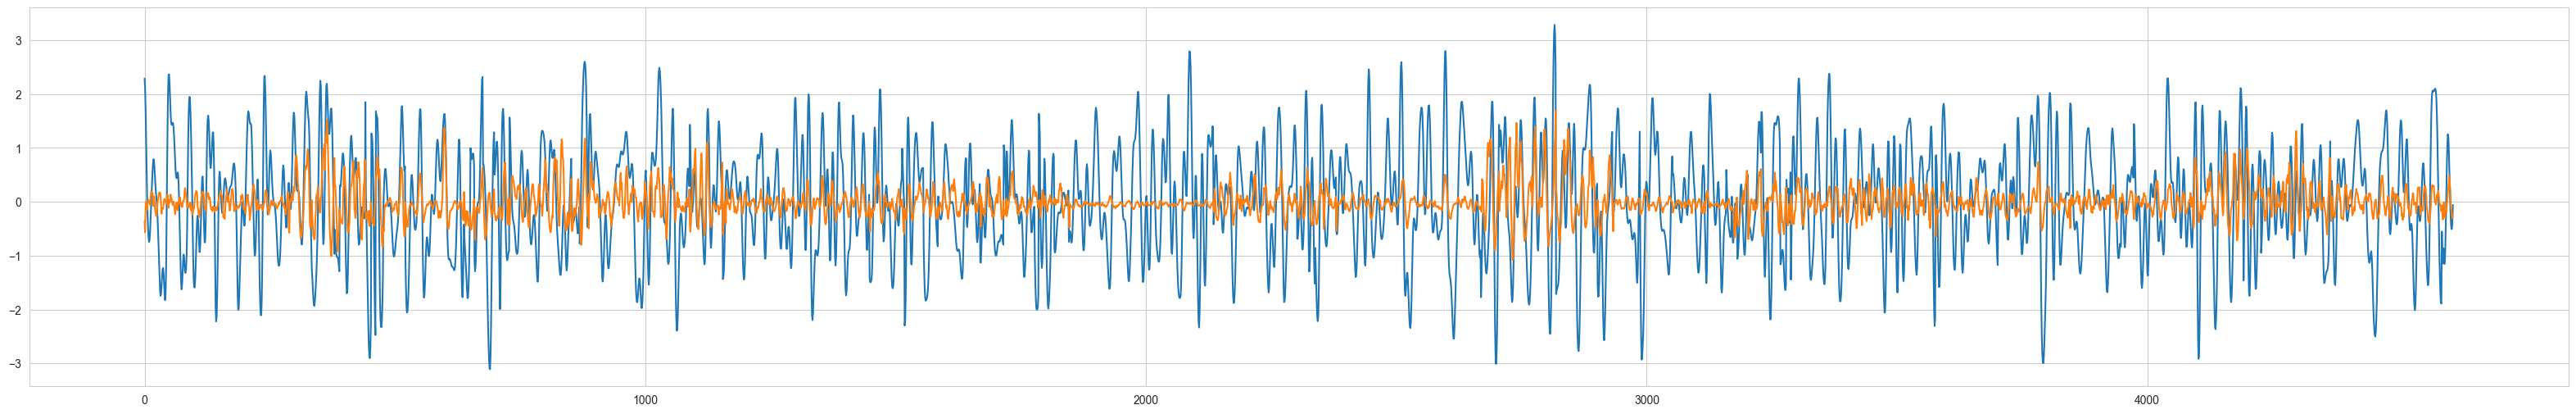

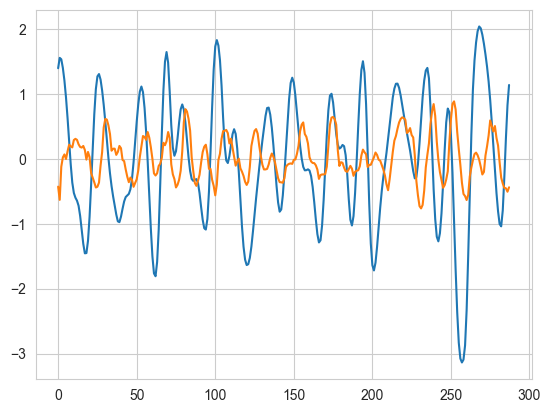

(4611, 86)
0.1435837722262082


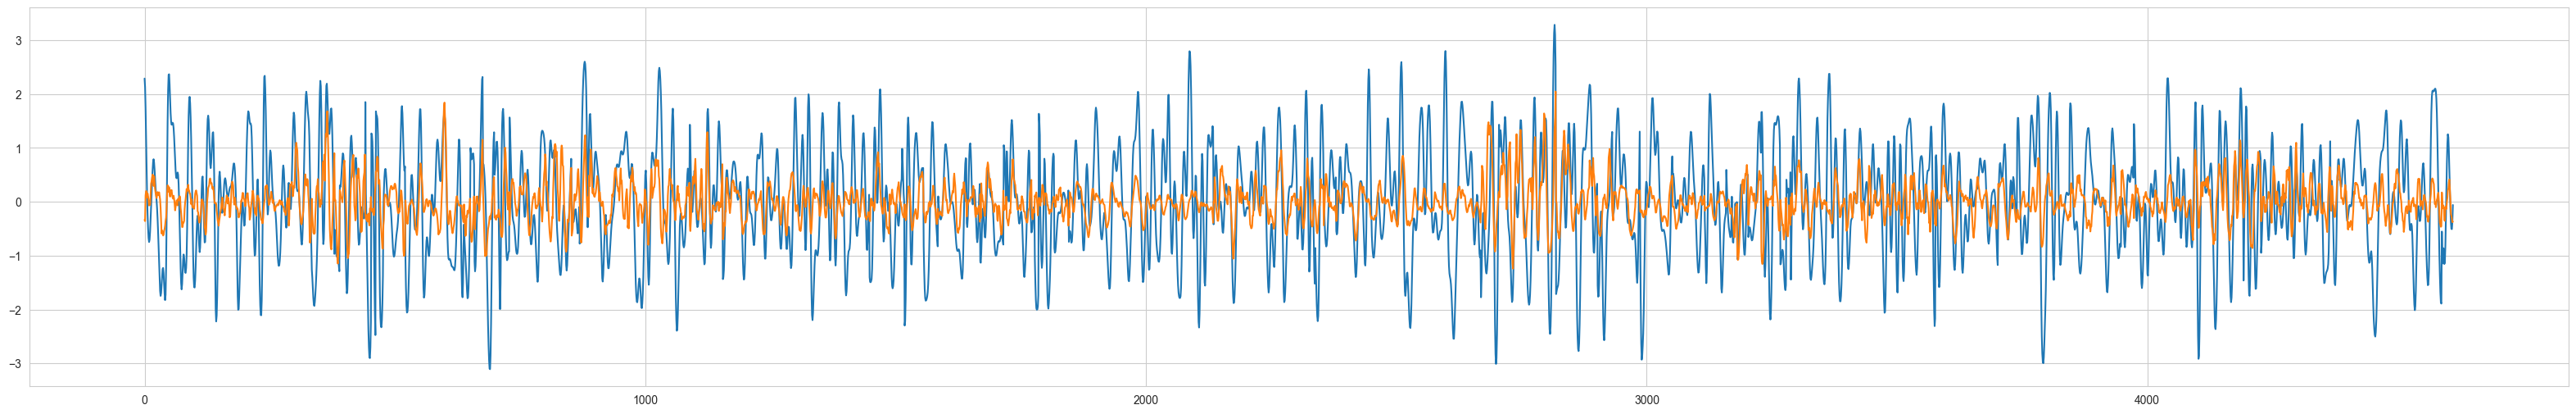

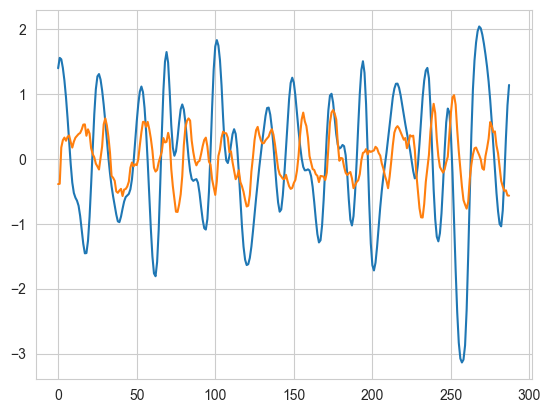

In [12]:
TEST_SUB = np.random.choice(available_subjects)
for test_sub in [TEST_SUB]:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = False,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = True,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()

Text(0.5, 1.0, 'Ridge Regression Correlation monkey1_run-01')

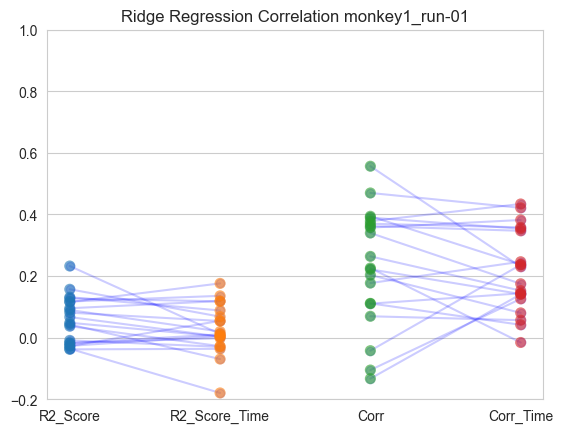

In [13]:
CORR_Ridge = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_Ridge,s = 8,alpha = 0.6,jitter = False)
# sns.lineplot(x='Corr_Time',y='Corr',data = corr_df)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([-0.2,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Ridge Regression Correlation '+ tasks_list[0])


In [14]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
available_subjects = []
tasks_list = ['monkey1_run-01']
for subject in SUBJECTS:
    key = 'sub-' + subject+'_ses-'+session +'_task-'+ tasks_list[0]
    if key in data_brainstates.keys():
        available_subjects.append(subject)
        
for test_sub in available_subjects:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = False,model = 'rf')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,available_subjects,session,state,tasks_list,time = True,model = 'rf')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(4611, 36)
(4611, 86)
0.2158907054822431 0.3023094620131017
0.03756573060514179 0.0812079891072689
02
(4710, 36)
(4710, 86)
0.2889858906937455 0.2735128835112628
0.061705288904164934 0.050878734235990764
03
(4717, 36)
(4717, 86)
0.5069866043685426 0.11934305369614932
0.21035319720955103 -0.057331029780404164
04
(4611, 36)
(4611, 86)
0.056519971862808716 0.08345182989756803
-0.1037738325710782 -0.09029264842112195
05
(4672, 36)
(4672, 86)
0.2304620929027464 0.2771123721839628
0.02385365558096042 0.06156852922373568
06
(4625, 36)
(4625, 86)
0.24510129504079126 0.22607498552463226
0.04628631906582292 0.029519372839982516
07
(4611, 36)
(4611, 86)
0.19660873498803977 0.009719832695929206
0.028693274359255283 -0.10445089335967506
08
(4678, 36)
(4678, 86)
0.22637520445544404 0.057775217668440064
0.041569068608378945 -0.0681569115103624
09
(4722, 36)
(4722, 86)
0.10053137513773089 0.22282104495288363
-0.009612563261166995 0.04443285800382557
10
(4610, 36)
(4610, 86)
-0.012687078727521848 0.

16
(4610, 36)
0.18251217739320819


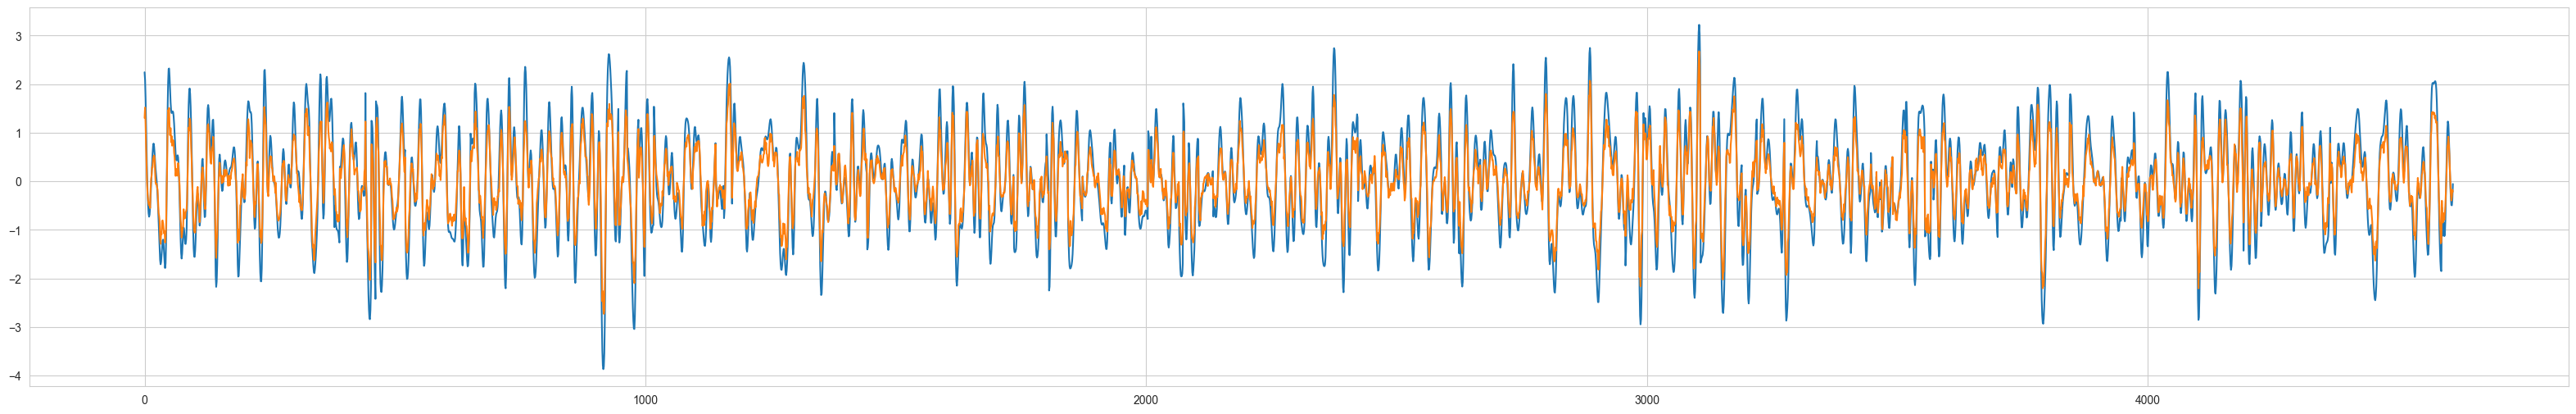

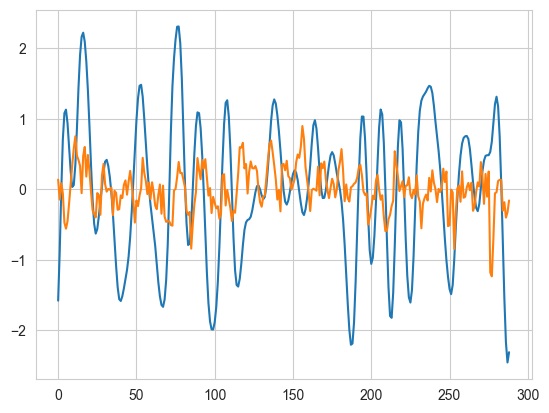

(4610, 86)
0.07143087142496905


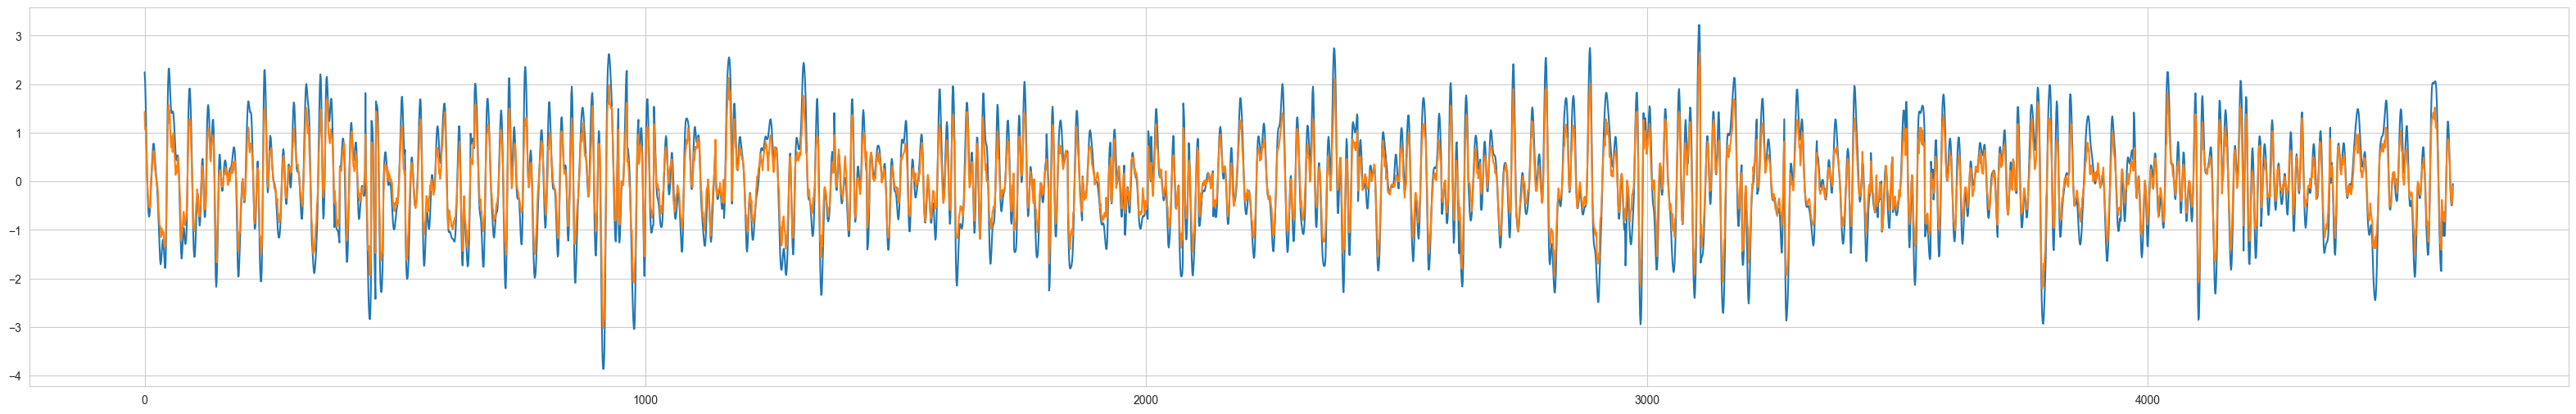

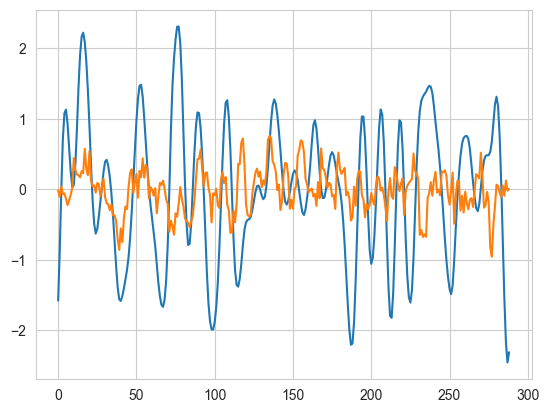

In [15]:
TEST_SUB = np.random.choice(available_subjects)

for test_sub in [TEST_SUB]:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = False,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(TEST_SUB,available_subjects,session,state,tasks_list,time = True,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()

[0.03756573060514179, 0.061705288904164934, 0.21035319720955103, -0.1037738325710782, 0.02385365558096042, 0.04628631906582292, 0.028693274359255283, 0.041569068608378945, -0.009612563261166995, -0.03495296796472047, 0.013817660712798108, 0.12720496882018173, 0.05485094218660913, -0.025383336814486457, -0.07527832273538393, 0.04224644193760396, 0.07062941444538706, 0.009308696299868968, 0.10400722995925282, 0.043030078910799685]
[0.0812079891072689, 0.050878734235990764, -0.057331029780404164, -0.09029264842112195, 0.06156852922373568, 0.029519372839982516, -0.10445089335967506, -0.0681569115103624, 0.04443285800382557, -0.07684898207513413, 0.08232673976254912, 0.08014241354575635, -0.08250819809502885, -0.06743824899657169, -0.060106657056484325, -0.07096462556081384, 0.024356598599846402, -0.13566553761857247, 0.024340301180865498, -0.030398817968715353]


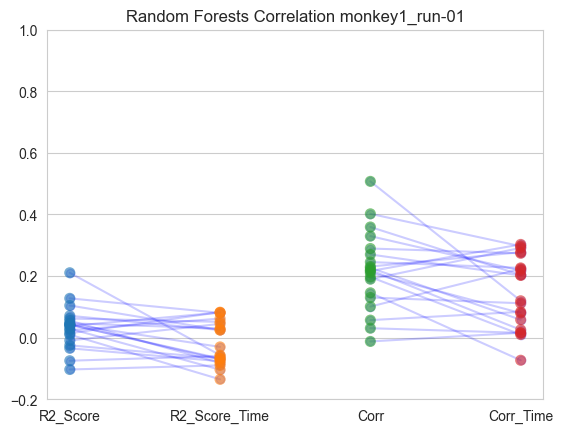

In [16]:
CORR_RF = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_RF,s = 8,alpha = 0.6,jitter = False)
for idx, row in CORR_RF.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_RF.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([0,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Random Forests Correlation '+ tasks_list[0])
print(R2_score)
print(R2_score_TIME)